## Backtesting Dollar Cost Averaging on Degiro's ETF Core Selection Playground

**Dollar Cost Averaging?**
From Investopedia: "Dollar-cost averaging involves investing the same amount of money in a target security at regular intervals over a certain period of time, regardless of price. By using dollar-cost averaging, investors may lower their average cost per share and reduce the impact of volatility on the their portfolios." With applying this strategy long-term, you hope that the average buying price of the ETF you are buying converges to the expected value.

An example of this would be to buy 100$ worth of the S&P500 at the start of each month.

**Why Degiro?**
Degiro is a broker commonly used for buy-and-hold investors since they offer low transactions costs. They have a group of ETFs on which you only pay a 1€ handling fee on the first purchase of an ETF from that group per month. Which is very ideal for long term investing.

The dataset used is up until 22 September 2024.

Author: N. Yu (nick.j.k.yu@gmail.com)

### TODOs
 
 - [x] Account for dividends
 - [ ] Account for different currency of equity
 - [x] Account for inflation rate
 - [ ] Other metrics: e.g. XIRR, sharpe, max drawdown
 - [ ] Effect of increasing input with time

## 1. Get data

We first need the list of ETFs on Degiro's Core Selection, they nicely provide this on their website.

In [1]:
%%capture
!pip install requests pandas yfinance seaborn pyxirr

In [2]:
!wget -nc https://www.degiro.nl/assets/js/data/core-selection-list-nl.csv

File ‘core-selection-list-nl.csv’ already there; not retrieving.



We will be using Yahoo finance to get historical data, but first we need the ticker symbol for each ETF.
Only the ISIN is provided, we can query Yahoo Finance for the ticker using the ISIN.

In [3]:
import pandas as pd

df_core_selection = pd.read_csv('core-selection-list-nl.csv')

# First row is an additional header, skip
df_core_selection = df_core_selection.iloc[1:]

df_core_selection.head()

,product,isin,exchange,benchmark,region,esgRating,totalExpanseRation,translateView,linkKid
1,ISHARES EURO STX50,IE0008471009,Euronext Amsterdam & Tradegate,Euro STOXX 50,Europa,AA,0.1,Bekijk,https://doc.morningstar.com/LatestDoc.aspx?cli...
2,ISHARES CHINA 25,IE00B02KXK85,Euronext Amsterdam & Tradegate,FTSE China 25,China,A,0.74,Bekijk,https://doc.morningstar.com/LatestDoc.aspx?cli...
3,ISHARES FTSE 100,IE0005042456,Euronext Amsterdam & Tradegate,FTSE 100-index,United Kingdom,AA,0.07,Bekijk,https://doc.morningstar.com/LatestDoc.aspx?cli...
4,ISHARES ESTOXX DIV,IE00B0M62S72,Euronext Amsterdam & Tradegate,STOXX Europe Select Dividend 30,Europa,AA,0.4,Bekijk,https://doc.morningstar.com/LatestDoc.aspx?cli...
5,ISHARES AEX,IE00B0M62Y33,Euronext Amsterdam & Tradegate,AEX Total Net Return,Europa,AA,0.3,Bekijk,https://doc.morningstar.com/LatestDoc.aspx?cli...


In [4]:
import time
import json
from pathlib import Path

import requests

if Path('tickers.json').is_file():
    with open('tickers.json', 'r') as f:
        tickers = json.load(f)
else:
    user_agent_headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
    }
    
    url = 'https://query2.finance.yahoo.com/v1/finance/search?q={isin}'

    tickers = {}
    
    with requests.Session() as s:
        for isin in df_core_selection['isin']:
            # Crude rate-limiting
            time.sleep(0.1)
            
            response = s.get(url.format(isin=isin), headers=user_agent_headers)
            quotes = response.json()['quotes']
    
            if len(quotes) == 0:
                print(f'Could not find yf data for {isin}')
                continue
            
            ticker = quotes[0]['symbol']
            tickers[isin] = ticker
    
    with open('tickers.json', 'w+') as f:
        json.dump(tickers, f)

## 2. Get historical pricing data from Yahoo Finance

We now have a dict of `ISIN: Ticker`, with `yfinance` we can get the pricing data from the inception date of the ETF

In [5]:
import yfinance as yf
from yfinance.exceptions import YFPricesMissingError

for isin, ticker in tickers.items():
    try:
        df = yf.Ticker(ticker).history(period='max', raise_errors=True)
        df.to_csv(f'data/{isin}-{ticker}.csv')
    except YFPricesMissingError:
        pass

$FR0007052782.SG: possibly delisted; No price data found  (1d 1925-10-19 -> 2024-09-24)
$IE00B44T3H88.SG: possibly delisted; No price data found  (1d 1925-10-19 -> 2024-09-24)
$IE00BMC38736.SG: possibly delisted; No price data found  (1d 1925-10-19 -> 2024-09-24)
$IE000I8KRLL9.SG: possibly delisted; No price data found  (1d 1925-10-19 -> 2024-09-24)
$IE00BMDH1538.SG: possibly delisted; No price data found  (1d 1925-10-19 -> 2024-09-24)
$IE00BMDKNW35.SG: possibly delisted; No price data found  (1d 1925-10-19 -> 2024-09-24)
$IE00BNG8L278.SG: possibly delisted; No price data found  (1d 1925-10-19 -> 2024-09-24)


In [6]:
vwrl_isin = 'IE00B3RBWM25'
vwrl_ticker = tickers[vwrl_isin]
df = pd.read_csv(f'data/{vwrl_isin}-{vwrl_ticker}.csv', parse_dates=['Date'])
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
3113,2024-09-18 00:00:00+01:00,135.669998,135.820007,135.190002,135.199997,25748,0.0,0.0,0.0
3114,2024-09-19 00:00:00+01:00,136.899994,137.570007,136.673004,137.449997,15721,0.0,0.0,0.0
3115,2024-09-20 00:00:00+01:00,137.350006,137.899994,136.520004,136.600006,43344,0.0,0.0,0.0
3116,2024-09-23 00:00:00+01:00,137.259995,137.779999,136.649994,137.479996,19985,0.0,0.0,0.0
3117,2024-09-24 00:00:00+01:00,137.910004,138.110001,137.779999,138.070007,4061,0.0,0.0,0.0


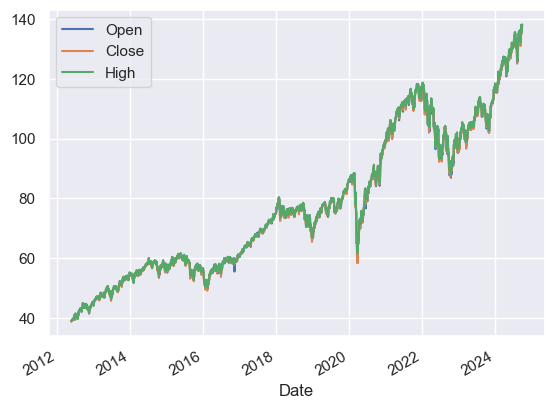

In [7]:
import seaborn as sns
sns.set_theme()

_ = df.plot(x='Date', y=['Open', 'Close', 'High'])

## 3. Backtesting

We use a very simple strategy.

At the start of each month, we invest a set amount of cash. Using the total available cash, we buy as many equities as possible. 

Assumptions
- All dividends are reinvested
- The user is in the Netherlands, we use Consumer Price Index (CPI) data from the dutch Centraal Bureau voor de Statistiek (CBS)
- We do not take currency exchange into account. We assume the user invests using the currency of the security.
- We assume that we buy at the first day of the month at market open, so we use the open price as the buying price
  
We backtest and calculate the following metrics:
- `equity_peak` the peak value of the portfolio during the entire duration of investing
- `equity_final` the value of the total number of equities at the most recent date
- `total_expense` the total amount of cash invested over the entire period
- `BEP` break-even-price
- `real_return` the return over the total amount of cash invested, which is defined as

$$
Nominal~Return = \frac{\#Equities \cdot Price - Expense + Remaining~Cash}{Expense}
$$

$$
Return = (\frac{1 + Nominal~Return}{1 + Inflation~Rate} - 1) \cdot 100\%
$$

e.g. If you invested 100$ over a period of 12 months using some the following example stock data

| **Month**    | **Stock Price (start of month)** | **Owned Stocks** | **Remaining Cash** |
|--------------|-----------------|------------------|-------------------|
| January      | 88.60           | 1                | 11.40             |
| February     | 50.15           | 3                | 11.10             |
| March        | 52.97           | 5                |  5.16             |
| April        | 66.76           | 6                | 38.04             |
| May          | 72.90           | 7                | 65.05             |
| June         | 80.03           | 9                |  5.44             |
| July         | 69.18           | 10               | 36.26             |
| August       | 73.68           | 11               | 62.58             |
| September    | 67.29           | 13               | 28.00             |
| October      | 62.61           | 15               |  2.78             |
| November     | 66.58           | 16               | 36.02             |
| December     | 71.20           | 17               | 64,82             |

Let's say the final price at the end of december is 75, and there is a transaction cost of 2$ and there is an annual inflation rate of 5% then you would have a return of

$$Expense = \# Months \cdot (Invested + Transaction~Cost) = 12 \cdot (100 + 2) = 1224$$
$$
Nominal~Return = \frac{17 \cdot 75 - 1224 + 64,82}{12 \cdot 100} \cdot 100\% = \frac{1275 - 1224 + 64,82}{1200} \cdot 100\% \approx 9,65\%
$$
$$
Return = \frac{1 + 0.0965}{1 + 0.05} - 1 \approx 0,04428 \cdot 100\% \approx 4,43 \%
$$


In [8]:
# To calculate the inflation rate, we use the Consumer Price Index as an approximation 
df_cpi = pd.read_csv('cpi_nl_all_items.csv', delimiter=';')
df_cpi['Year'] = df_cpi['Periods'].apply(lambda p: int(p.split('MM')[0]))
df_cpi['Month'] = df_cpi['Periods'].apply(lambda p: int(p.split('MM')[1]))

df_cpi = df_cpi[['Year', 'Month', 'CPI_1', 'DerivedCPI_2']]
df_cpi.tail()

,Year,Month,CPI_1,DerivedCPI_2
339,2024,4,129.42,127.52
340,2024,5,129.69,127.79
341,2024,6,129.91,127.53
342,2024,7,131.82,129.26
343,2024,8,132.24,129.67


In [9]:
import datetime

from pyxirr import xirr

def backtest(df, cash=0, monthly_input=500, transaction_cost=1, years_to_date=10, dividend_tax_cut=0.15):
    total_expense = 0
    equity = 0
    equity_peak = 0
    transactions = []
    portfolio_worth = []
    cash_flow = []
    
    metrics = {}

    # Get starting date, threshold to earliest date available
    # simplify ytd to 365
    start_date = df.iloc[-1]['Date'] - datetime.timedelta(days=365*years_to_date)
    if start_date < df.iloc[0]['Date']:
        start_date = df.iloc[0]['Date']
    
    metrics['start'] = start_date
    metrics['end'] = df.iloc[-1]['Date']
    metrics['duration'] = metrics['end'] - metrics['start']
    
    current_month = None

    # Filter rows on start date
    df = df[df['Date'] > start_date]
    
    for row in df.to_dict(orient='records'):
    
        date = row['Date']

        # edge case, no data
        if row['Open'] == 0:
            continue

        # account for dividends
        if row['Dividends'] > 0:
            dividends = (1 - dividend_tax_cut) * equity * row['Dividends']

            # reinvest dividends
            cash += dividends
            
            cash_flow.append((date.date(), dividends))
        
        # detect new month, assume data is in ascending order
        if date.month != current_month:
            current_month = date.month
    
            # buy using available cash
            cash += monthly_input
            total_expense += monthly_input
            cash_flow.append((date.date(), -monthly_input))
    
            to_buy = int((cash - transaction_cost) / row['Open'])

            # If we have enough money to buy shares, buy as much as possible
            if to_buy > 0:
                cash = cash - transaction_cost - to_buy * row['Open']
                equity += to_buy
                total_expense += transaction_cost

                transactions.append((date, to_buy, row['Open'], cash))
    
        portfolio_worth.append((date, equity, total_expense, equity * row['Open'], cash))
        
        equity_high = equity * row['High']
        if equity_high > equity_peak:
            equity_peak = equity_high
    
    metrics['equity_peak'] = equity_peak
    metrics['equity_final'] = df.iloc[-1]['Open'] * equity
    metrics['total_expense'] = total_expense
    metrics['BEP'] = total_expense / equity
    metrics['current'] = df.iloc[-1]['Open']
    metrics['unrealized_nominal_return'] = metrics['equity_final'] - total_expense
    metrics['nominal_return'] = ((metrics['equity_final'] - total_expense) / total_expense)

    # Calculate inflation adjusted real values
    cpi_start = float(df_cpi.loc[(df_cpi['Year'] == metrics['start'].year) & (df_cpi['Month'] == metrics['start'].month)]['DerivedCPI_2'].iloc[0])
    cpi_end = df_cpi.iloc[-1]['DerivedCPI_2']
    inflation_rate = (cpi_end - cpi_start) / cpi_start
    metrics['inflation_rate'] = inflation_rate
    metrics['real_return'] = ((1 + metrics['nominal_return']) / (1 + inflation_rate)) - 1

    # Calculate XIRR
    # TODO: inflation accounted cash flow
    cash_flow.append((metrics['end'], metrics['equity_final']))
    # metrics['XIRR'] = xirr(cash_flow)
    
    return metrics, transactions, portfolio_worth


metrics, transactions, portfolio_worth = backtest(df, monthly_input=100, years_to_date=20)
metrics

{'start': Timestamp('2012-05-22 00:00:00+0100', tz='UTC+01:00'),
 'end': Timestamp('2024-09-24 00:00:00+0100', tz='UTC+01:00'),
 'duration': Timedelta('4508 days 00:00:00'),
 'equity_peak': 32732.07014465332,
 'equity_final': np.float64(32684.670867919922),
 'total_expense': 15045,
 'BEP': 63.48101265822785,
 'current': np.float64(137.91000366210938),
 'unrealized_nominal_return': np.float64(17639.670867919922),
 'nominal_return': np.float64(1.1724606758338267),
 'inflation_rate': np.float64(0.32437953222347043),
 'real_return': np.float64(0.6403611072020514)}

## 4. Visualize the results

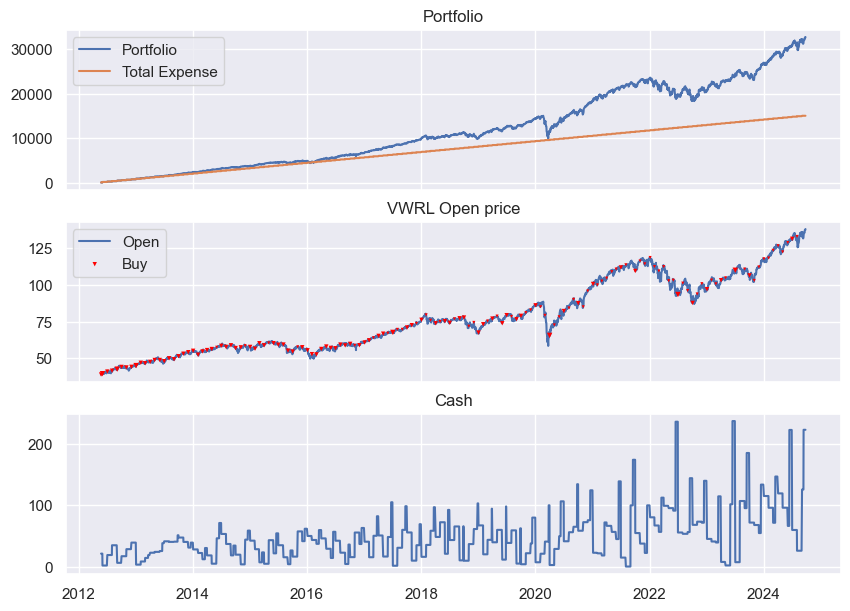

In [10]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))

axs[0].plot([r[0] for r in portfolio_worth], [r[3] for r in portfolio_worth], label='Portfolio')
axs[0].plot([r[0] for r in portfolio_worth], [r[2] for r in portfolio_worth], label='Total Expense')
axs[0].set_title('Portfolio')
axs[0].legend()

axs[1].set_title('VWRL Open price')
df.plot(x='Date', y='Open', ax=axs[1], legend=None)
axs[1].scatter(
    [r[0] for r in transactions], 
    [float(df.loc[df['Date'] == r[0]]['Open'].iloc[0]) for r in transactions], 
    s=[r[1]*5 for r in transactions],
    c='red', marker='v', zorder=2, linewidths=0.5, edgecolors='none', label='Buy'
)
axs[1].legend()

axs[2].plot([r[0] for r in portfolio_worth], [r[4] for r in portfolio_worth], label='Cash')
_ = axs[2].set_title('Cash')

In [11]:
import csv

all_metrics = []

for isin, ticker in tickers.items():
    if not Path(f'data/{isin}-{ticker}.csv').is_file():
        continue

    df = pd.read_csv(f'data/{isin}-{ticker}.csv', parse_dates=['Date'])

    # XXX: empty data
    if len(df) == 0:
        continue

    metrics = {}
    metrics['ticker'] = ticker
    metrics['isin'] = isin
    
    m, _, _ = backtest(df, monthly_input=500, years_to_date=20)
    metrics.update(m)
    
    all_metrics.append(metrics)

df_all = pd.DataFrame(all_metrics)
df_all.to_csv('metrics.csv')
df_all.head()

,ticker,isin,start,end,duration,equity_peak,equity_final,total_expense,BEP,current,unrealized_nominal_return,nominal_return,inflation_rate,real_return
0,EUEAA.XC,IE0008471009,2022-11-10 00:00:00+00:00,2024-09-19 00:00:00+01:00,678 days 23:00:00,13437.519836,13421.440491,11523,42.996269,50.080002,1898.440491,0.164752,0.039272,0.120738
1,FXC.L,IE00B02KXK85,2009-01-02 00:00:00+00:00,2024-09-24 00:00:00+01:00,5743 days 23:00:00,101673.000000,73092.000000,94512,7876.000000,6091.000000,-21420.000000,-0.226638,0.416539,-0.454048
2,ISF.L,IE0005042456,2009-01-02 00:00:00+00:00,2024-09-24 00:00:00+01:00,5743 days 23:00:00,121954.096273,119576.448242,94646,639.500000,807.948975,24930.448242,0.263407,0.416539,-0.108103
3,IDVY.AS,IE00B0M62S72,2008-01-02 00:00:00+01:00,2024-09-24 00:00:00+02:00,6109 days 23:00:00,222434.681780,221408.290255,100701,8.241345,18.120001,120707.290255,1.198670,0.436946,0.530099
4,IAEX.AS,IE00B0M62Y33,2008-01-02 00:00:00+01:00,2024-09-24 00:00:00+02:00,6109 days 23:00:00,322936.083826,312133.106850,100701,29.265039,90.709999,211432.106850,2.099603,0.436946,1.157077


## Winners and losers

In [12]:
df_all.sort_values(by='nominal_return').iloc[-5:][['ticker', 'nominal_return', 'BEP', 'current']]

,ticker,nominal_return,BEP,current
21,CSSPX.MI,2.269761,166.678846,545.000000
37,XDWT.L,3.463259,20.092939,89.680000
31,CSNDX.SW,3.527070,251.155807,1137.000000
38,WTEC.L,4.267594,31.982343,168.470001
11,EQQQ.MI,5.170405,70.966173,437.890015


In [13]:
df_all.sort_values(by='real_return').iloc[-5:][['ticker', 'real_return', 'BEP', 'current', 'start']]

,ticker,real_return,BEP,current,start
35,IUIT.L,1.379586,10.253826,31.690001,2015-11-20 00:00:00+00:00
31,CSNDX.SW,2.217163,251.155807,1137.000000,2010-01-26 00:00:00+01:00
37,XDWT.L,2.241000,20.092939,89.680000,2010-11-22 00:00:00+00:00
38,WTEC.L,2.745041,31.982343,168.470001,2009-02-13 00:00:00+00:00
11,EQQQ.MI,3.294111,70.966173,437.890015,2008-01-02 00:00:00+01:00


In [14]:
df_all.sort_values(by='real_return').iloc[:5][['ticker', 'real_return', 'BEP', 'current']]

,ticker,real_return,BEP,current
63,FOOD.L,-1.000000,4.677871,0.0000
1,FXC.L,-0.454048,7876.000000,6091.0000
59,KWEB.L,-0.374059,24.719249,19.3720
64,HTWO.L,-0.366709,5.772192,4.4395
14,EXXY.DE,-0.244725,22.772727,24.7150


## Does increasing monthly input have an effect on return?

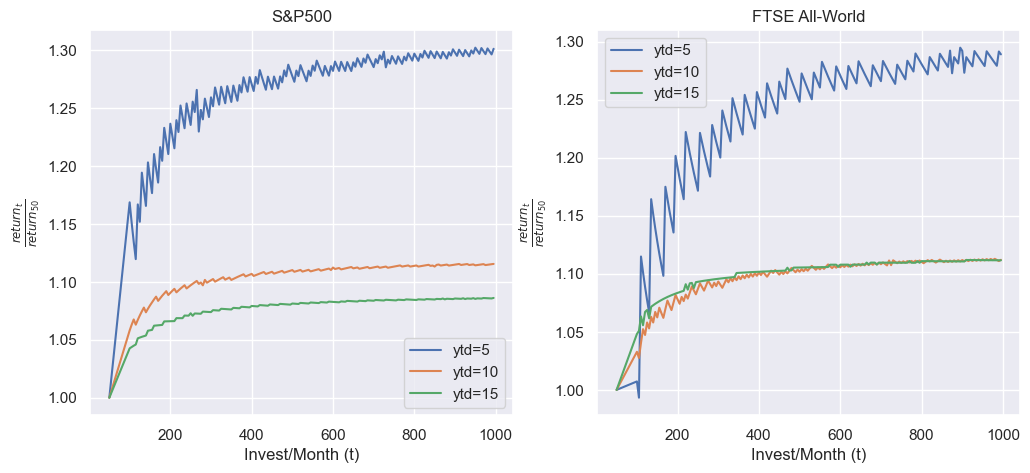

In [15]:
vwrl_isin = 'IE00B3RBWM25'
sp500_isin = 'IE00B3XXRP09'

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

df = pd.read_csv(f'data/{sp500_isin}-{tickers[sp500_isin]}.csv', parse_dates=['Date'])
for ytd in (5, 10, 15):
    base, _, _ = backtest(df, monthly_input=50, years_to_date=ytd)
    metrics = [
        (50, 1)
    ]
    for monthly_input in range(100, 1000, 5):
        ret, _, _ = backtest(df, monthly_input=monthly_input, years_to_date=ytd)
        metrics.append((monthly_input, ret['real_return'] / base['real_return']))
    
    axs[0].plot([x[0] for x in metrics], [x[1] for x in metrics], label=f'ytd={ytd}')

axs[0].set_title('S&P500')
axs[0].set_ylabel(r'$\frac{return_t}{return_{50}}$')
axs[0].set_xlabel('Invest/Month (t)')
axs[0].legend()

df = pd.read_csv(f'data/{vwrl_isin}-{tickers[vwrl_isin]}.csv', parse_dates=['Date'])
for ytd in (5, 10, 15):
    base, _, _ = backtest(df, monthly_input=50, years_to_date=ytd)
    metrics = [
        (50, 1)
    ]
    for monthly_input in range(100, 1000, 5):
        ret, _, _ = backtest(df, monthly_input=monthly_input, years_to_date=ytd)
        metrics.append((monthly_input, ret['real_return'] / base['real_return']))
    
    axs[1].plot([x[0] for x in metrics], [x[1] for x in metrics], label=f'ytd={ytd}')

axs[1].set_title('FTSE All-World')
axs[1].set_ylabel(r'$\frac{return_t}{return_{50}}$')
axs[1].set_xlabel('Invest/Month (t)')
axs[1].legend();

It seems like increasing input does increase the relative return. The function follows a logarithmic curve, so it eventually converges to a maximum return. Something to investigate is using an investment value relative to the price of the security. But for the S&P500 and All-world, which are priced <120, anywhere >400 seems to be the sweet spot.

### Conclusion

Using simple backtesting, we can see that the Invesco EQQQ (Nasdaq-100) seems to have the historically strongest growth, outperforming the S&P500 even. However, QQQs P/E ratio is quite high, which is a bit riskier. It is also much less diversified, with a lot in tech.

In [16]:
!jupyter nbconvert --to html backtest.ipynb

[NbConvertApp] Converting notebook backtest.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 622497 bytes to backtest.html
